<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch9_PowerMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The power method

Ch 9.1, 9.2 in Burden and Faires

##Learning objectives
- The book has two algorithms (one is "for symmetric matrices only)", but they're really the same
- But if you have a symmetric matrix, the convergence really is faster
- If we have an unlucky starting guess, what happens?
- Doing deflation the proper and improper ways
- Shift-and-invert


*Copyright 2025 Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause lciense*

In [1]:
import numpy as np
import scipy.linalg as sla
from matplotlib import pyplot as plt

Create two matrices, $A$ and $B$, which have the same eigenvalues but one is symmetric and one isn't

In [2]:
A = np.array( [[1,2,3],[0,5,3],[0,0,-7]] ) # an obviously asymmetric matrix
n = A.shape[0]
print('The matrix A is')
print(A)
print('which has eigenvalues')
print(np.real_if_close( sla.eigvals(A) ))
print('and singular values')
print(sla.svdvals(A))

print('')
print('and the matrix B is')
rng = np.random.default_rng(123)
e   = sla.eigvals(A)
V   = sla.qr(rng.standard_normal((n,n)))[0] # pick some new singular vectors
B   = np.real_if_close( V.T @ np.diag(e) @ V )
with np.printoptions(precision=3):
  print(B)
  print('which has eigenvalues')
  print(sla.eigvalsh(B)) # no need to do real_if_close when using eigvalsh
  print('and singular values')
  print(sla.svdvals(B))

The matrix A is
[[ 1  2  3]
 [ 0  5  3]
 [ 0  0 -7]]
which has eigenvalues
[ 1.  5. -7.]
and singular values
[8.74567816 4.43848322 0.90165412]

and the matrix B is
[[-1.175 -2.93   2.314]
 [-2.93   1.011  4.692]
 [ 2.314  4.692 -0.836]]
which has eigenvalues
[-7.  1.  5.]
and singular values
[7. 5. 1.]


In [3]:
def power_iter(A, x=None, maxits = 100 ):
  """ Power method, Algorithm 9.2 in Burden and Faires.
  They imply this for symmetric matrices only, which is incorrect. """
  if x is None:
      x = np.ones( A.shape[0])
  else:
      x = x.copy()
  x /= np.linalg.norm(x)
  muList = []
  for k in range(maxits):
      y = A @ x
      mu = np.dot(y,x)
      x = y/np.linalg.norm(y)
      # print(mu)
      muList.append(mu)
  return np.array(muList), x

Here's a helper function that we'll use a bit:

In [4]:
def signed_max(v, return_index=False):
  """ returns the maximum entry (in absolute value) with its sign """
  k = np.argmax(np.abs(v))
  if not np.isscalar(k):
      k = k[0] # if there is more than one location, take the first
  if return_index:
      return v[k], k
  else:
      return v[k]

Which eigenvalue do we expect the power method to converge to?

In [6]:
lam    = signed_max(sla.eigvalsh(B)) # not calling it "lambda" since that's a special keyword in Python
print(lam)

-7.0000000000000036


Run the power method on both matrices

In [5]:
muList, v         = power_iter(A)
muList_sym, v_sym = power_iter(B)

Plot the convergence rates (eigenvalues only) for the method, applied to the symmetric and asymemtric matrix

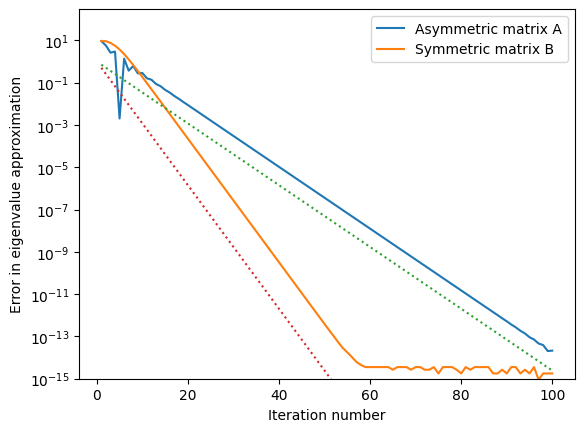

In [7]:
kList  = np.arange(1,len(muList)+1)

plt.semilogy(kList,np.abs(muList-lam),    label='Asymmetric matrix A')
plt.semilogy(kList,np.abs(muList_sym-lam),label='Symmetric matrix B')
# Some reference lines
plt.semilogy(kList,(5/7)**kList, ':' )
plt.semilogy(kList,(5/7)**(2*kList), ':' )
plt.ylim(bottom=1e-15)
plt.legend()
plt.ylabel('Error in eigenvalue approximation')
plt.xlabel('Iteration number')
plt.show()

## What if we have an unlucky starting guess?
If our starting guess is $\vec{x}_0$ and we're looking for the dominant eigenpair $(\lambda_1,\vec{v}_1)$ then we need $\langle \vec{x}_0, \vec{v}_1 \rangle \neq 0$ for the power method to work. You might be worried that it's hard to guarantee this.

So let's see what happens when $\langle \vec{x}_0, \vec{v}_1 \rangle = 0$. We'll use scipy's eigensolver to get $\vec{v}_1$, then pick some $\vec{x}_0$ and then process it to ensure $\langle \vec{x}_0, \vec{v}_1 \rangle = 0$.

What do you think will happen?

In [8]:
# Step one: find the dominant eigenvalue/eigenvector
e,V = sla.eigh(B)

lam, k = signed_max(sla.eigvalsh(B), return_index=True)
v = V[:,k]
v /= np.linalg.norm(v)
print(v)

# Double-check that we really have an eigenvector
print( (B@v) / v )

[-0.53390673 -0.56415724  0.6298176 ]
[-7. -7. -7.]


In [11]:
# Step 2:
# Pick any starting vector, but let's *try* to make it orthogonal
# If we do this perfectly, the power method will fail...
x0 = rng.standard_normal(B.shape[0])
x0 -= np.dot(x0,v)*v

print(np.dot(x0,v) )

-5.551115123125783e-17


3.3306690738754696e-16


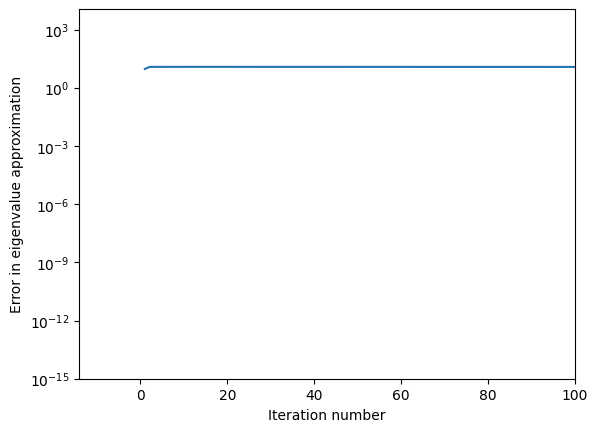

In [9]:
# Step 3: run the power method, initialized at this point
muList_sym, v_sym = power_iter(B,x=x0,maxits=200)

kList  = np.arange(1,len(muList_sym)+1)
plt.semilogy(kList,np.abs(muList_sym-lam) )
plt.semilogy(105+kList,(5/7)**kList, ':' )
plt.semilogy(105+kList,(5/7)**(2*kList), ':' )
plt.ylim(bottom=1e-15)
plt.xlim(right=100)
plt.ylabel('Error in eigenvalue approximation')
plt.xlabel('Iteration number')
plt.show()

Let's plot it again, but adjust the x-axis

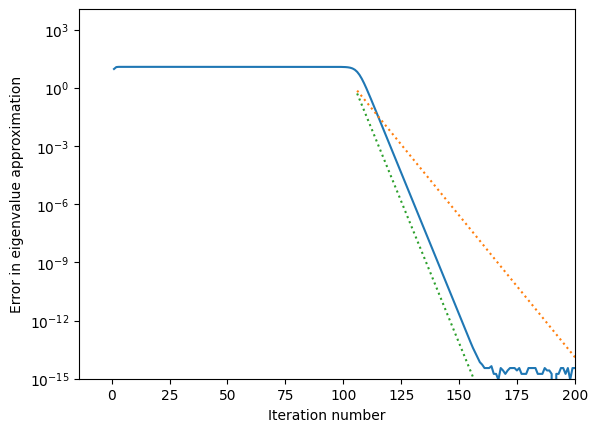

In [10]:
plt.semilogy(kList,np.abs(muList_sym-lam) )
plt.semilogy(105+kList,(5/7)**kList, ':' )
plt.semilogy(105+kList,(5/7)**(2*kList), ':' )
plt.ylim(bottom=1e-15)
plt.xlim(right=200)  # <--- adjust this
plt.ylabel('Error in eigenvalue approximation')
plt.xlabel('Iteration number')
plt.show()

## Compare the two algorithms

In [12]:
def power_iter_ver2(A, x=None, maxits = 100, tol = 1e-6 ):
  """ This is Algo 9.1 in Burden and Faires
  It normalizes in a fancy way so that the eigenvector converges"""
  if x is None:
      x = np.ones( A.shape[0])
  else:
      x = x.copy()
  x /= signed_max(x)
  muList = []
  for k in range(maxits):
      y = A @ x

      # mu = np.dot(y,x) # Algo 9.2
      # x = y/np.linalg.norm(y)

      mu = signed_max(y) # Algo 9.1
      err = np.linalg.norm(x - y/mu, np.inf )
      if err < tol:
          break
      x = y/mu

      # print(mu)
      muList.append(mu)
  return np.array(muList), x

Run Example 2 (p. 591 in section 5.2) which does both the Power method (Algo 9.1) and the Symmetric Power method (9.2) to the same matrix.

In [13]:
A = np.array( [[4,-1,1],[-1,3,-2],[1,-2,3]], dtype=float )
print('The matrix A is')
print(A)
print('which has eigenvalues')
print(np.real_if_close( sla.eigvals(A) ))
x0 = np.array([1.,0,0]) # another way to force this to be floating pt is to use "1." instead of "1"
muList_92, v_92 = power_iter(A)
muList_91, v_91 = power_iter_ver2(A,tol=1e-15)

The matrix A is
[[ 4. -1.  1.]
 [-1.  3. -2.]
 [ 1. -2.  3.]]
which has eigenvalues
[3. 6. 1.]


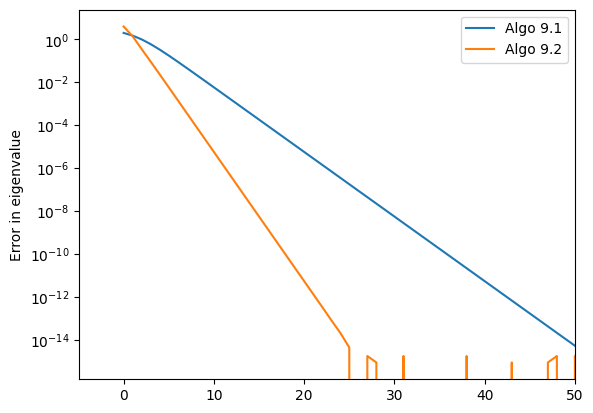

In [14]:
lam = 6 # eigenvalue it converges to
plt.semilogy( np.abs(muList_91-lam), label='Algo 9.1' )
plt.semilogy( np.abs(muList_92-lam), label='Algo 9.2' )
plt.legend()
plt.ylabel('Error in eigenvalue')
plt.xlim(right=50)
plt.show()

So the algorithms seem different

But really, it's just computing the estimate of the eigenvalue different. The iterations are (basically) the same

What do we mean by "basically"? Well, they find the same *eigenspace*. Recall that eigenvectors are not uniquely defined, since you can always scale them. The two methods scale the eigenvectors differently, but they are *aligned* with each other.

One way to see this is to look at their **correlation**. If they are perfectly correlated, it means they are aligned.

In [19]:
maxits = 30
muList_92, v_92 = power_iter(     A,maxits = maxits)
muList_91, v_91 = power_iter_ver2(A,maxits = maxits)
np.corrcoef(v_91,v_92)[0,1] - 1

np.float64(-1.9118040484045196e-13)

For any "maxits", their correlation is 1, up to roundoff error